In [1]:
# Import neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Import Seasonality - Trend decomposition
from statsmodels.tsa.seasonal import STL

# Import model
from xgboost import XGBRegressor
from prophet import Prophet

# Import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [2]:
# Read data from csv file and make a data frame
orders = pd.read_csv("./datasets/restaurant-1-orders.csv")
orders

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6
...,...,...,...,...,...,...
74813,2518,18/05/2016 18:53,House Red wine 75cl,2,17.95,7
74814,2503,14/05/2016 19:28,House Red wine 75cl,2,17.95,6
74815,2467,10/05/2016 13:18,House Red wine 75cl,2,17.95,9
74816,2249,07/04/2016 19:04,House white wine 75cl,1,17.95,6


In [3]:
# Check NaN value of dataset
orders.isna().sum()

Order Number      0
Order Date        0
Item Name         0
Quantity          0
Product Price     0
Total products    0
dtype: int64

In [4]:
# Describe the dataset
orders.describe()

,Order Number,Quantity,Product Price,Total products
count,74818.000000,74818.000000,74818.000000,74818.000000
mean,9115.638162,1.243564,5.286492,6.931434
std,4052.210452,0.798207,3.338221,3.954832
min,630.000000,1.000000,0.500000,1.000000
25%,5590.000000,1.000000,2.950000,5.000000
50%,9103.000000,1.000000,3.950000,6.000000
75%,12630.000000,1.000000,8.950000,8.000000
max,16118.000000,51.000000,17.950000,60.000000


In [5]:
# Get the info of each column
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order Number    74818 non-null  int64  
 1   Order Date      74818 non-null  object 
 2   Item Name       74818 non-null  object 
 3   Quantity        74818 non-null  int64  
 4   Product Price   74818 non-null  float64
 5   Total products  74818 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB


In [6]:
# Convert the order date column to the datetime
orders['Order Date'] = pd.to_datetime(orders['Order Date'], dayfirst=True)
orders

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,2019-08-03 20:25:00,Plain Papadum,2,0.80,6
1,16118,2019-08-03 20:25:00,King Prawn Balti,1,12.95,6
2,16118,2019-08-03 20:25:00,Garlic Naan,1,2.95,6
3,16118,2019-08-03 20:25:00,Mushroom Rice,1,3.95,6
4,16118,2019-08-03 20:25:00,Paneer Tikka Masala,1,8.95,6
...,...,...,...,...,...,...
74813,2518,2016-05-18 18:53:00,House Red wine 75cl,2,17.95,7
74814,2503,2016-05-14 19:28:00,House Red wine 75cl,2,17.95,6
74815,2467,2016-05-10 13:18:00,House Red wine 75cl,2,17.95,9
74816,2249,2016-04-07 19:04:00,House white wine 75cl,1,17.95,6


In [7]:
# Get the total order of each date
orders_quantity_by_date = orders[['Order Date', 'Quantity']].resample('D', on='Order Date').sum().reset_index()
orders_quantity_by_date

,Order Date,Quantity
0,2015-09-01,1
1,2015-09-02,0
2,2015-09-03,0
3,2015-09-04,0
4,2015-09-05,0
...,...,...
1428,2019-07-30,100
1429,2019-07-31,87
1430,2019-08-01,65
1431,2019-08-02,132


In [8]:
# Find the min value of order date
min_date = orders_quantity_by_date['Order Date'].min()
min_date

Timestamp('2015-09-01 00:00:00')

In [9]:
# Find the max value of order date
max_date = orders_quantity_by_date['Order Date'].max()
max_date

Timestamp('2019-08-03 00:00:00')

In [10]:
# Get the top 5 most sold dish
top_5_dish = orders[['Item Name', 'Quantity']].groupby(by='Item Name').sum().sort_values(by='Quantity', ascending=False).reset_index()
top_5_dish.head(5)

,Item Name,Quantity
0,Plain Papadum,10648
1,Pilau Rice,6367
2,Plain Naan,4983
3,Garlic Naan,3318
4,Plain Rice,2964


In [11]:
top_5_dish.iloc[0]['Item Name']

'Plain Papadum'

In [12]:
# Return the 5 least sold products
top_5_dish.tail(5)

,Item Name,Quantity
243,Chicken Chaat Main,1
244,Lamb Persian,1
245,Kurma,1
246,Mushroom - Prawn,1
247,Tandoori Chicken,1


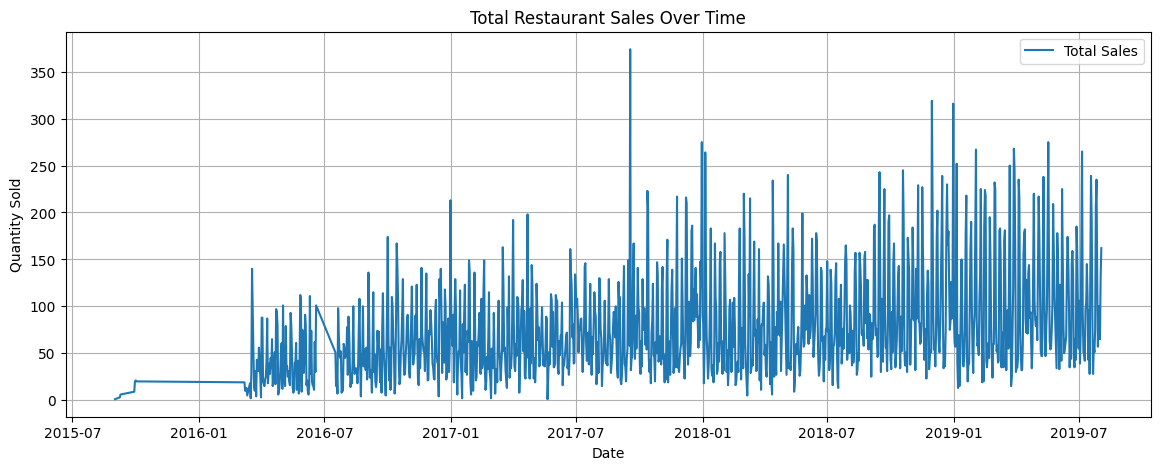

In [13]:
# Visualize daily sale
daily_sales = orders.groupby(orders['Order Date'].dt.date)['Quantity'].sum().reset_index()
plt.figure(figsize=(14, 5))
plt.plot(daily_sales['Order Date'], daily_sales['Quantity'], label='Total Sales')
plt.title("Total Restaurant Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.legend()
plt.show()

In [14]:
# Find missing day
full_range = pd.date_range(start=min_date, end=max_date)
missing = set(full_range) - set(orders['Order Date'].unique())
print(f'Count of missing day: {len(missing)}')

Count of missing day: 1433


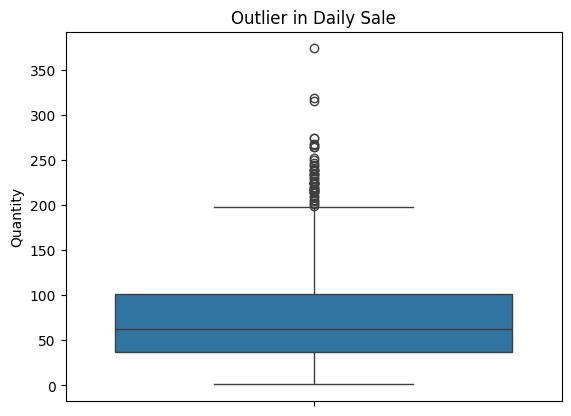

In [15]:
# Visualize the outlier
sns.boxplot(data=daily_sales, y='Quantity')
plt.title('Outlier in Daily Sale')
plt.show()

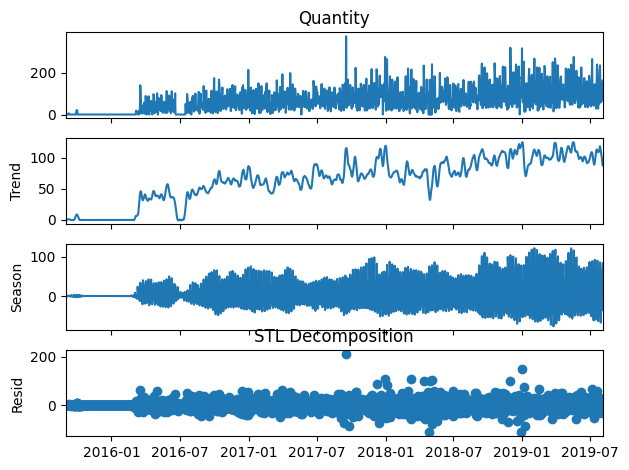

In [16]:
# Seasonality and trend decomposition
daily_sales = daily_sales.set_index('Order Date')
daily_sales = daily_sales.asfreq('D', fill_value=0)  # Fill missing days with 0
stl = STL(daily_sales['Quantity'], period=7)
res = stl.fit()
res.plot()
plt.title('STL Decomposition')
plt.show()

In [17]:
# Let make the histogram to see the distribution order of each year.
# Add the column Year and Month
orders['Year'] = orders['Order Date'].dt.year
orders['Month'] = orders['Order Date'].dt.month

# Return Month/Year data frame
month_year_df = orders.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()
month_year_df

,Year,Month,Quantity
0,2015,9,39
1,2015,10,41
2,2016,3,690
3,2016,4,1168
4,2016,5,1280
5,2016,6,780
6,2016,7,606
7,2016,8,1416
8,2016,9,1468
9,2016,10,2088


C:\Users\famsu\AppData\Local\Temp\ipykernel_16208\3204304985.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Month')['Quantity'].sum().reset_index()
C:\Users\famsu\AppData\Local\Temp\ipykernel_16208\3204304985.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Month')['Quantity'].sum().reset_index()
C:\Users\famsu\AppData\Local\Temp\ipykernel_16208\3204304985.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt t

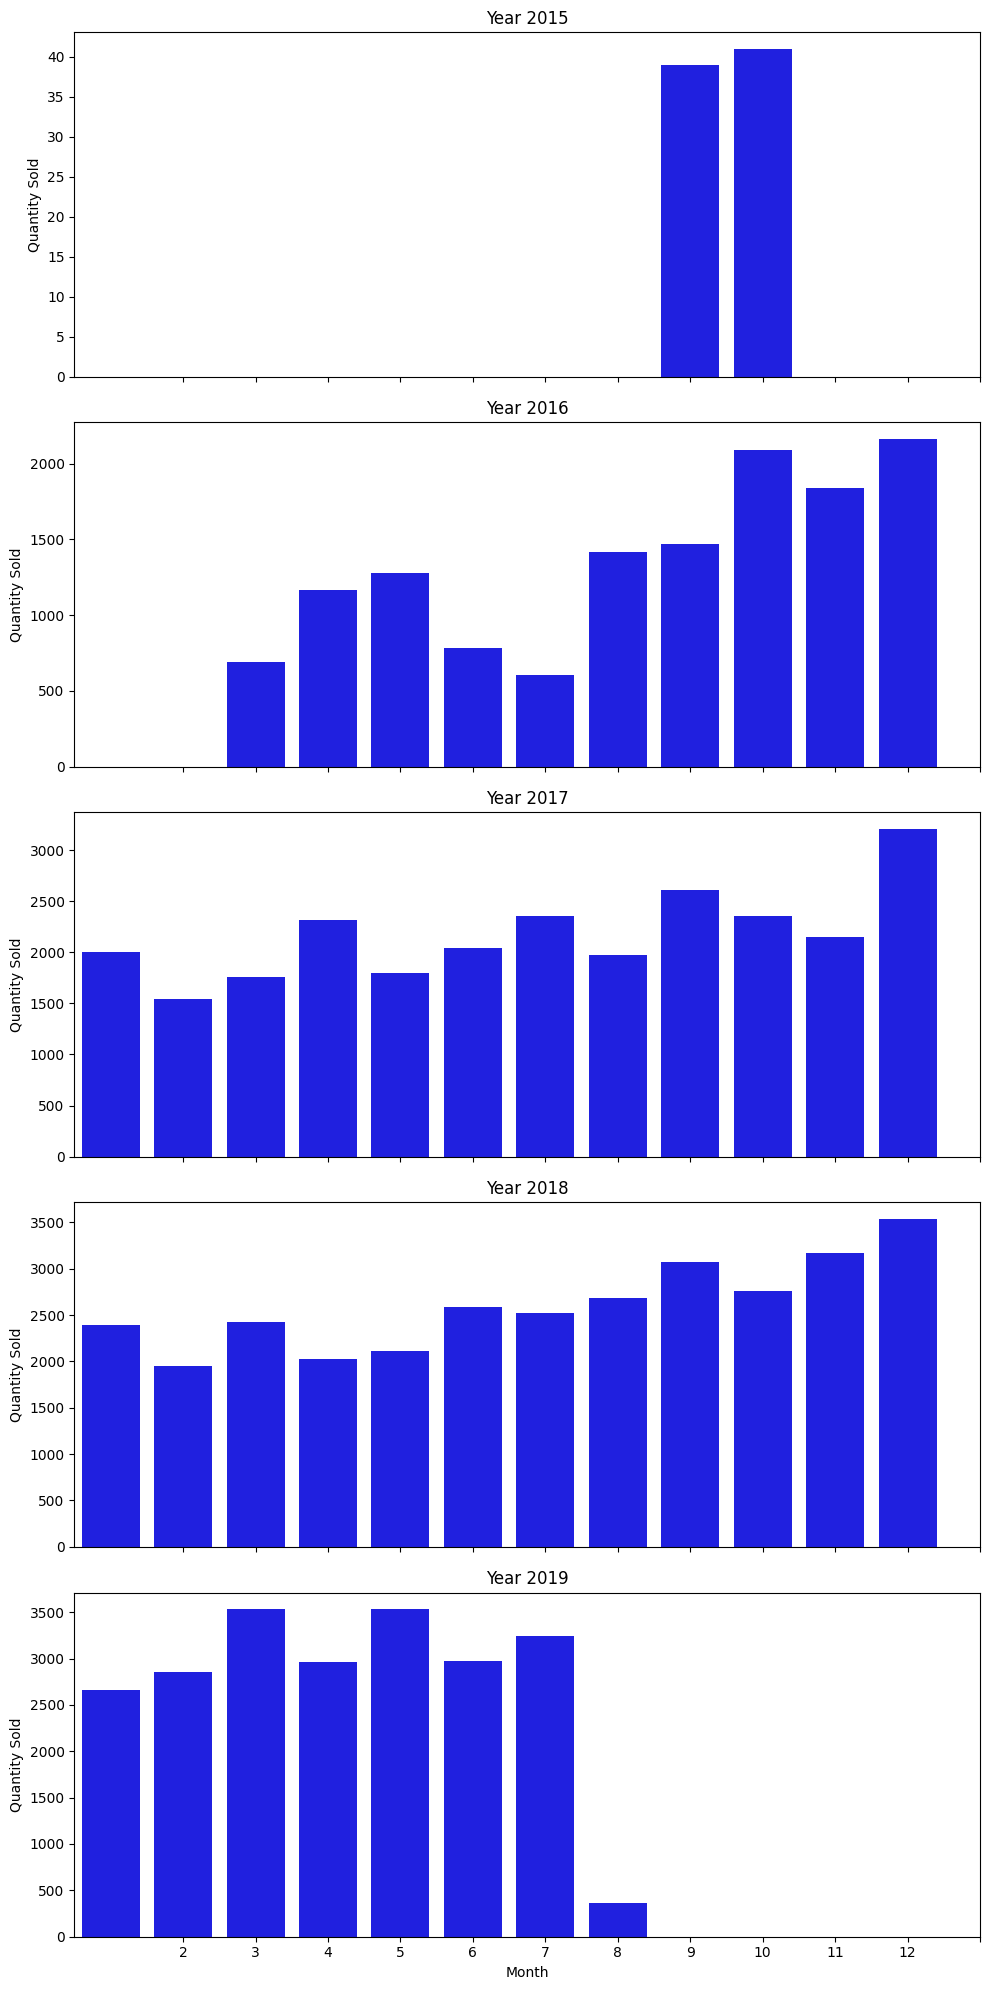

In [18]:
# Visualize the sale distribution by month
month_year_df['Month'] = pd.Categorical(
    month_year_df['Month'], categories=range(1, 13), ordered=True
)
years = month_year_df['Year'].unique()
num_years = len(years)
fig, axes = plt.subplots(nrows=num_years, ncols=1, figsize=(10, num_years * 4), sharex=True)
bin_edges = np.linspace(0.5, 12.5, 13)
for i, year in enumerate(years):
    ax = axes[i]
    data = month_year_df[month_year_df['Year'] == year]
    # sns.histplot(data, x='Month', weights='Quantity', bins=12, kde=True, ax=ax, color='skyblue')
    # Use the histoplot to visualisation the distribution. Got the issue with display the histogram. Some bars are thin or thick
    # The visualization show the 
    # ax.bar(data['Month'], data['Quantity'], color='skyblue')
    grouped = data.groupby('Month')['Quantity'].sum().reset_index()
    sns.barplot(data=grouped, x='Month', y='Quantity', ax=ax, color='blue')

    ax.set_title(f"Year {year}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Quantity Sold")
    ax.set_xticks(range(1, 13))  # Ensure months are labeled correctly

plt.tight_layout()
plt.show()

C:\Users\famsu\AppData\Local\Temp\ipykernel_16208\2965612546.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_year_df.groupby('Month')['Quantity'].mean().plot(kind='bar')


<Axes: xlabel='Month'>

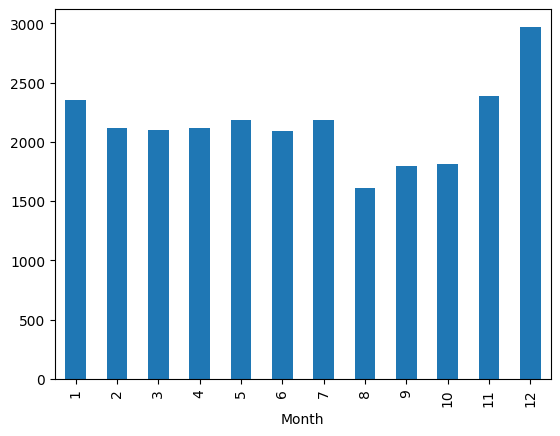

In [19]:
# Show the most sold month by avg
month_year_df.groupby('Month')['Quantity'].mean().plot(kind='bar')
# From the histogram, we can see, that December has the most sold by avg.

In [20]:
# Use prophet model to predict future sale
prophet_df = orders.groupby(orders['Order Date'].dt.date)['Quantity'].sum().reset_index()
# Fill the missing date with 0 (currently, do not count the problem of data lost)
full_range = pd.date_range(start=prophet_df['Order Date'].min(), end=prophet_df['Order Date'].max(), freq='D')
prophet_df = prophet_df.set_index('Order Date').reindex(full_range, fill_value=0).reset_index()
prophet_df = prophet_df.rename(columns={'index': 'ds', 'Quantity': 'y'})
prophet_df

,ds,y
0,2015-09-01,1
1,2015-09-02,0
2,2015-09-03,0
3,2015-09-04,0
4,2015-09-05,0
...,...,...
1428,2019-07-30,100
1429,2019-07-31,87
1430,2019-08-01,65
1431,2019-08-02,132


In [21]:
# Use 200 last record as test
prophet_train = prophet_df[:-14]
prophet_test = prophet_df[-14:]

# Create model and train
prophet_model = Prophet()
prophet_model.fit(prophet_train)

16:04:56 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
prophet_future = prophet_model.make_future_dataframe(periods=14)
forecast = prophet_model.predict(prophet_future)
predicted = forecast.set_index('ds').loc[prophet_test['ds']]['yhat'].values
actual = prophet_test['y'].values

prophet_rmse = mean_squared_error(actual, predicted)
print("Prophet RMSE:", prophet_rmse)

Prophet RMSE: 1198.83610158875


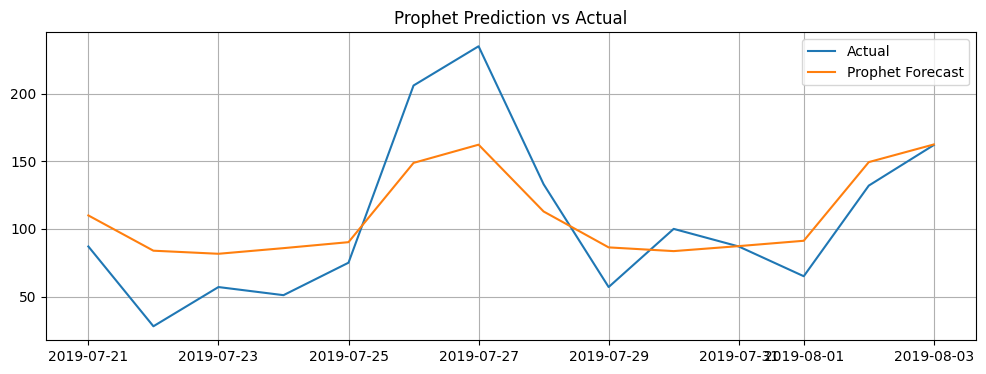

In [23]:
# Visualization the prediction
# Prophet
plt.figure(figsize=(12, 4))
plt.plot(prophet_test['ds'], actual, label='Actual')
plt.plot(prophet_test['ds'], predicted, label='Prophet Forecast')
plt.title("Prophet Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Create dataset for xgboost model
xgb_df = orders.groupby(orders['Order Date'].dt.date)['Quantity'].sum().reset_index()
# Convert column Order Date into Datetime
xgb_df['Order Date'] = pd.to_datetime(xgb_df['Order Date'], dayfirst=True)
# Add additional columns like day, month, weekday
xgb_df['day'] = xgb_df['Order Date'].dt.day
xgb_df['month'] = xgb_df['Order Date'].dt.month
xgb_df['weekday'] = xgb_df['Order Date'].dt.weekday

# Add lag features
for i in range(1, 15):  # lag 2 week
    xgb_df[f'Quantity_{i}'] = xgb_df['Quantity'].shift(i)
xgb_df = xgb_df.dropna()
xgb_df

,Order Date,Quantity,day,month,weekday,Quantity_1,Quantity_2,Quantity_3,Quantity_4,Quantity_5,Quantity_6,Quantity_7,Quantity_8,Quantity_9,Quantity_10,Quantity_11,Quantity_12,Quantity_13,Quantity_14
14,2016-03-17,29,17,3,3,2.0,18.0,5.0,13.0,13.0,10.0,19.0,20.0,21.0,20.0,9.0,6.0,3.0,1.0
15,2016-03-18,140,18,3,4,29.0,2.0,18.0,5.0,13.0,13.0,10.0,19.0,20.0,21.0,20.0,9.0,6.0,3.0
16,2016-03-19,93,19,3,5,140.0,29.0,2.0,18.0,5.0,13.0,13.0,10.0,19.0,20.0,21.0,20.0,9.0,6.0
17,2016-03-20,51,20,3,6,93.0,140.0,29.0,2.0,18.0,5.0,13.0,13.0,10.0,19.0,20.0,21.0,20.0,9.0
18,2016-03-21,14,21,3,0,51.0,93.0,140.0,29.0,2.0,18.0,5.0,13.0,13.0,10.0,19.0,20.0,21.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,2019-07-30,100,30,7,1,57.0,133.0,235.0,206.0,75.0,51.0,57.0,28.0,87.0,191.0,239.0,141.0,28.0,96.0
1203,2019-07-31,87,31,7,2,100.0,57.0,133.0,235.0,206.0,75.0,51.0,57.0,28.0,87.0,191.0,239.0,141.0,28.0
1204,2019-08-01,65,1,8,3,87.0,100.0,57.0,133.0,235.0,206.0,75.0,51.0,57.0,28.0,87.0,191.0,239.0,141.0
1205,2019-08-02,132,2,8,4,65.0,87.0,100.0,57.0,133.0,235.0,206.0,75.0,51.0,57.0,28.0,87.0,191.0,239.0


In [25]:
# Split
X = xgb_df.drop(columns=['Order Date', 'Quantity'])
y = xgb_df['Quantity']

# Use last 200 row to test
X_train, X_test = X[:-14], X[-14:]
y_train, y_test = y[:-14], y[-14:]

model_xgb = XGBRegressor(early_stopping_rounds=30, n_estimators=700, learning_rate=0.2)
model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, num_parallel_tree=None, ...)

In [26]:
y_pred_xgb = model_xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost RMSE:", xgb_rmse)

XGBoost RMSE: 821.8699340820312


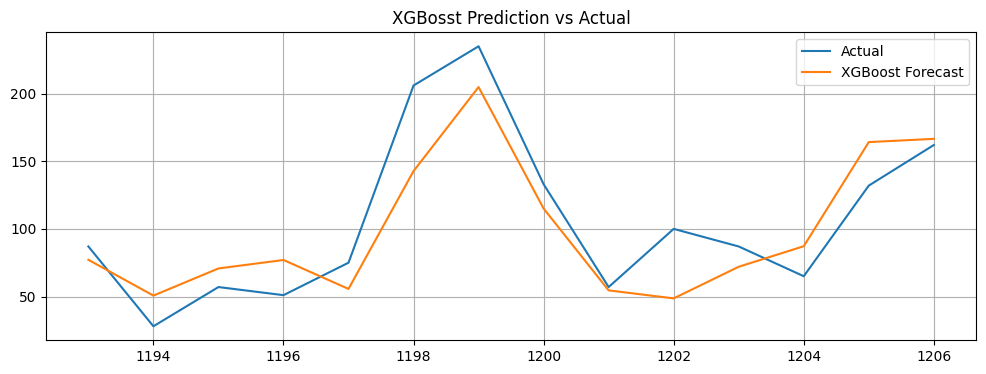

In [27]:
# Visualization the prediction
# XGBoost
plt.figure(figsize=(12, 4))
plt.plot(X_test.index, y_test.values, label='Actual')
plt.plot(X_test.index, y_pred_xgb, label='XGBoost Forecast')
plt.title("XGBosst Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Get German holidays the land is Bayern
import holidays
bayern_holidays = holidays.country_holidays('DE', subdiv='BY')
bayern_holidays

holidays.country_holidays('DE', subdiv='BY')

In [30]:
def get_season(date):
    y = date.year
    if pd.Timestamp(f'{y}-03-01') <= date < pd.Timestamp(f'{y}-06-01'):
        return 'spring'
    elif pd.Timestamp(f'{y}-06-01') <= date < pd.Timestamp(f'{y}-09-01'):
        return 'summer'
    elif pd.Timestamp(f'{y}-09-01') <= date < pd.Timestamp(f'{y}-12-01'):
        return 'autumn'
    else:
        return 'winter'

In [39]:
# Improvement for XGBoost
# Extract more feature from order date
# Create dataset for xgboost model
xgb_df_refined = orders.groupby(orders['Order Date'].dt.date)['Quantity'].sum().reset_index()
# Convert column Order Date into Datetime
xgb_df_refined['Order Date'] = pd.to_datetime(xgb_df_refined['Order Date'], dayfirst=True)
# Add additional columns like day, month, weekday
xgb_df_refined['day'] = xgb_df_refined['Order Date'].dt.day
xgb_df_refined['month'] = xgb_df_refined['Order Date'].dt.month
xgb_df_refined['weekday'] = xgb_df_refined['Order Date'].dt.weekday
# Check if it is the holiday
xgb_df_refined['is_holiday'] = (xgb_df_refined['Order Date'].dt.date.apply(lambda x: x in bayern_holidays)).astype(int)
# Check if it is weekend
xgb_df_refined['is_weekend'] = (xgb_df_refined['Order Date'].dt.weekday > 4).astype(int)
# Check the season
xgb_df_refined['season'] = xgb_df_refined['Order Date'].apply(get_season)

xgb_df_refined['is_spring'] = (xgb_df_refined['season'] == 'spring').astype(int)
xgb_df_refined['is_summer'] = (xgb_df_refined['season'] == 'summer').astype(int)
xgb_df_refined['is_autumn'] = (xgb_df_refined['season'] == 'autumn').astype(int)
xgb_df_refined['is_winter'] = (xgb_df_refined['season'] == 'winter').astype(int)
xgb_df_refined=xgb_df_refined.drop(columns=['season'])


# Add lag features
for i in range(1, 15):  # lag 2 week
    xgb_df_refined[f'Quantity_{i}'] = xgb_df_refined['Quantity'].shift(i)
xgb_df_refined = xgb_df_refined.dropna()
xgb_df_refined

,Order Date,Quantity,day,month,weekday,is_holiday,is_weekend,is_spring,is_summer,is_autumn,...,Quantity_5,Quantity_6,Quantity_7,Quantity_8,Quantity_9,Quantity_10,Quantity_11,Quantity_12,Quantity_13,Quantity_14
14,2016-03-17,29,17,3,3,0,0,1,0,0,...,13.0,10.0,19.0,20.0,21.0,20.0,9.0,6.0,3.0,1.0
15,2016-03-18,140,18,3,4,0,0,1,0,0,...,13.0,13.0,10.0,19.0,20.0,21.0,20.0,9.0,6.0,3.0
16,2016-03-19,93,19,3,5,0,1,1,0,0,...,5.0,13.0,13.0,10.0,19.0,20.0,21.0,20.0,9.0,6.0
17,2016-03-20,51,20,3,6,0,1,1,0,0,...,18.0,5.0,13.0,13.0,10.0,19.0,20.0,21.0,20.0,9.0
18,2016-03-21,14,21,3,0,0,0,1,0,0,...,2.0,18.0,5.0,13.0,13.0,10.0,19.0,20.0,21.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,2019-07-30,100,30,7,1,0,0,0,1,0,...,75.0,51.0,57.0,28.0,87.0,191.0,239.0,141.0,28.0,96.0
1203,2019-07-31,87,31,7,2,0,0,0,1,0,...,206.0,75.0,51.0,57.0,28.0,87.0,191.0,239.0,141.0,28.0
1204,2019-08-01,65,1,8,3,0,0,0,1,0,...,235.0,206.0,75.0,51.0,57.0,28.0,87.0,191.0,239.0,141.0
1205,2019-08-02,132,2,8,4,0,0,0,1,0,...,133.0,235.0,206.0,75.0,51.0,57.0,28.0,87.0,191.0,239.0


In [40]:
# Split
X = xgb_df_refined.drop(columns=['Order Date', 'Quantity'])
y = xgb_df_refined['Quantity']

# Use last 200 row to test
X_train, X_test = X[:-14], X[-14:]
y_train, y_test = y[:-14], y[-14:]

model_xgb_refined = XGBRegressor(early_stopping_rounds=30, n_estimators=700, learning_rate=0.2)
model_xgb_refined.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, num_parallel_tree=None, ...)

In [42]:
y_pred_xgb = model_xgb_refined.predict(X_test)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost RMSE:", xgb_rmse)

XGBoost RMSE: 802.4356689453125


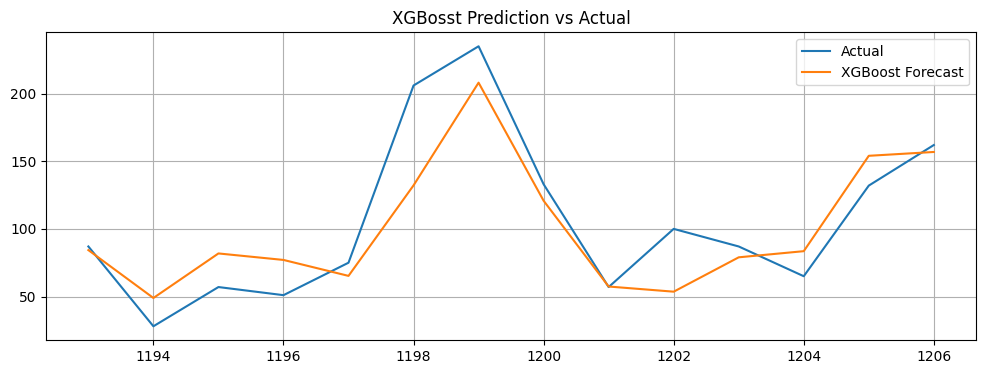

In [43]:
# Visualization the prediction
# XGBoost
plt.figure(figsize=(12, 4))
plt.plot(X_test.index, y_test.values, label='Actual')
plt.plot(X_test.index, y_pred_xgb, label='XGBoost Forecast')
plt.title("XGBosst Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [92]:
# From previous analysis Plain Papadum is the most sold dish
plain_papadum_df = orders[orders['Item Name'] == 'Plain Papadum'].groupby(orders['Order Date'].dt.date)['Quantity'].sum().reset_index()
# Fill the missing date with 0
full_range = pd.date_range(start=plain_papadum_df["Order Date"].min(), end=plain_papadum_df["Order Date"].max(), freq='D')
plain_papadum_df = plain_papadum_df.set_index('Order Date').reindex(full_range, fill_value=0).reset_index()
plain_papadum_df = plain_papadum_df.rename(columns={'index': 'ds', 'Quantity': 'y'})
plain_papadum_df

,ds,y
0,2016-03-17,6
1,2016-03-18,7
2,2016-03-19,5
3,2016-03-20,2
4,2016-03-21,0
...,...,...
1230,2019-07-30,8
1231,2019-07-31,8
1232,2019-08-01,7
1233,2019-08-02,19


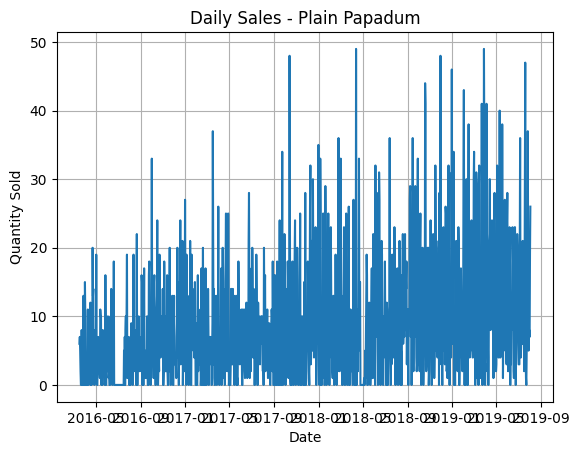

In [93]:
plt.plot(plain_papadum_df['ds'], plain_papadum_df['y'])
plt.title("Daily Sales - Plain Papadum")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.show()

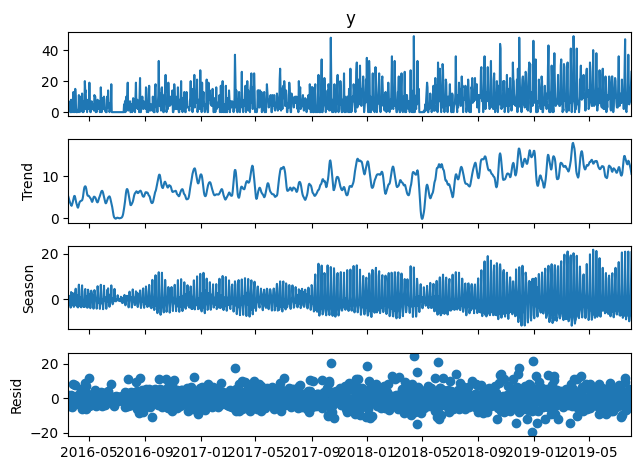

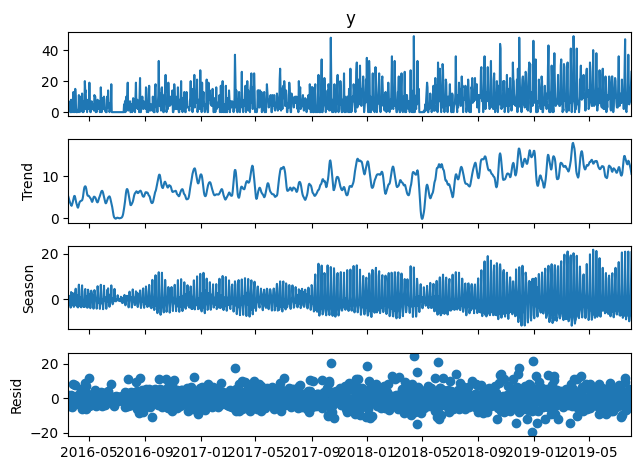

In [94]:
plain_papadum_df = plain_papadum_df.set_index('ds')
stl = STL(plain_papadum_df['y'])
result = stl.fit()
result.plot()

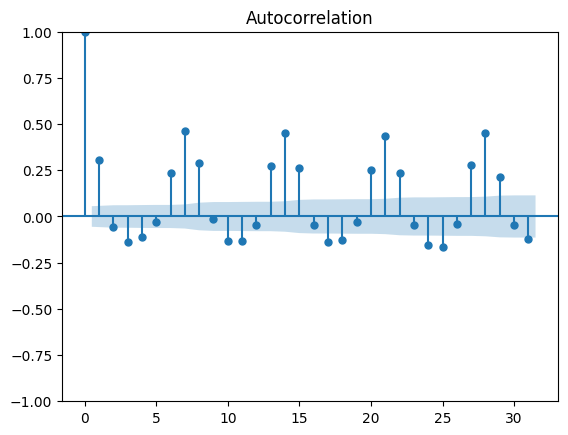

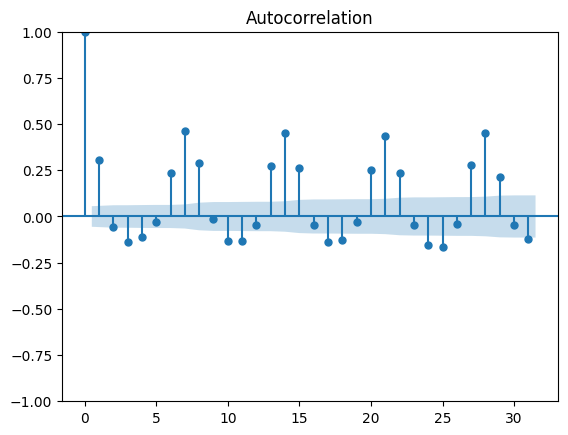

In [97]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(plain_papadum_df['y'])

In [107]:
plain_papadum_df = plain_papadum_df.reset_index()
plain_papadum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1235 non-null   datetime64[ns]
 1   y       1235 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.4 KB


In [108]:
plain_papadum_df_train = plain_papadum_df[:-14]
plain_papadum_df_test = plain_papadum_df[-14:]

# Create model and train
plain_papadum_prophet_model = Prophet()
plain_papadum_prophet_model.fit(plain_papadum_df_test)

20:26:31 - cmdstanpy - INFO - Chain [1] start processing
20:26:31 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
plain_papadum_pred = plain_papadum_prophet_model.make_future_dataframe(periods=14)
plain_papadum_forecast = plain_papadum_prophet_model.predict(plain_papadum_pred)
predicted = plain_papadum_forecast.set_index('ds').loc[prophet_test['ds']]['yhat'].values
actual = plain_papadum_df_test['y'].values

prophet_rmse = mean_squared_error(actual, predicted)
print("Prophet RMSE:", prophet_rmse)

Prophet RMSE: 83.76329243345626


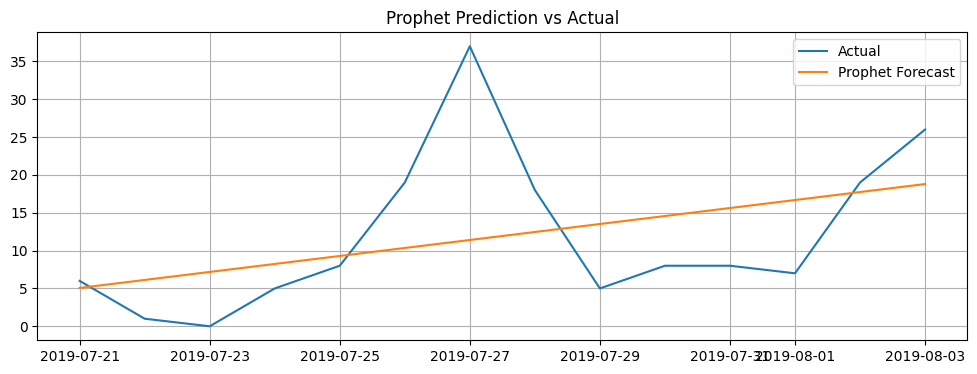

In [111]:
# Visualization the prediction
# Prophet
plt.figure(figsize=(12, 4))
plt.plot(plain_papadum_df_test['ds'], actual, label='Actual')
plt.plot(plain_papadum_df_test['ds'], predicted, label='Prophet Forecast')
plt.title("Prophet Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [125]:
# Use XGBoost to predict
xgb_plain_papadum_df = orders[orders['Item Name'] == 'Plain Papadum'].groupby(orders['Order Date'].dt.date)['Quantity'].sum().reset_index()
# Convert column Order Date into Datetime
xgb_plain_papadum_df['Order Date'] = pd.to_datetime(xgb_plain_papadum_df['Order Date'], dayfirst=True)
# Add additional columns like day, month, weekday
xgb_plain_papadum_df['day'] = xgb_plain_papadum_df['Order Date'].dt.day
xgb_plain_papadum_df['month'] = xgb_plain_papadum_df['Order Date'].dt.month
xgb_plain_papadum_df['weekday'] = xgb_plain_papadum_df['Order Date'].dt.weekday

# Add lag features
for i in range(1, 15):  # lag 2 week
    xgb_plain_papadum_df[f'Quantity_{i}'] = xgb_plain_papadum_df['Quantity'].shift(i)
xgb_plain_papadum_df = xgb_plain_papadum_df.dropna()
xgb_plain_papadum_df

,Order Date,Quantity,day,month,weekday,Quantity_1,Quantity_2,Quantity_3,Quantity_4,Quantity_5,Quantity_6,Quantity_7,Quantity_8,Quantity_9,Quantity_10,Quantity_11,Quantity_12,Quantity_13,Quantity_14
14,2016-04-10,1,10,4,6,11.0,3.0,1.0,10.0,15.0,6.0,13.0,1.0,5.0,8.0,2.0,5.0,7.0,6.0
15,2016-04-12,4,12,4,1,1.0,11.0,3.0,1.0,10.0,15.0,6.0,13.0,1.0,5.0,8.0,2.0,5.0,7.0
16,2016-04-13,10,13,4,2,4.0,1.0,11.0,3.0,1.0,10.0,15.0,6.0,13.0,1.0,5.0,8.0,2.0,5.0
17,2016-04-14,1,14,4,3,10.0,4.0,1.0,11.0,3.0,1.0,10.0,15.0,6.0,13.0,1.0,5.0,8.0,2.0
18,2016-04-15,2,15,4,4,1.0,10.0,4.0,1.0,11.0,3.0,1.0,10.0,15.0,6.0,13.0,1.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,2019-07-30,8,30,7,1,5.0,18.0,37.0,19.0,8.0,5.0,1.0,6.0,47.0,31.0,12.0,2.0,9.0,7.0
1015,2019-07-31,8,31,7,2,8.0,5.0,18.0,37.0,19.0,8.0,5.0,1.0,6.0,47.0,31.0,12.0,2.0,9.0
1016,2019-08-01,7,1,8,3,8.0,8.0,5.0,18.0,37.0,19.0,8.0,5.0,1.0,6.0,47.0,31.0,12.0,2.0
1017,2019-08-02,19,2,8,4,7.0,8.0,8.0,5.0,18.0,37.0,19.0,8.0,5.0,1.0,6.0,47.0,31.0,12.0


In [126]:
# Split
X = xgb_plain_papadum_df.drop(columns=['Order Date', 'Quantity'])
y = xgb_plain_papadum_df['Quantity']

# Use last 200 row to test
X_train, X_test = X[:-14], X[-14:]
y_train, y_test = y[:-14], y[-14:]

model_xgb = XGBRegressor(early_stopping_rounds=30, n_estimators=700, learning_rate=0.2)
model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, num_parallel_tree=None, ...)

In [127]:
y_pred_xgb = model_xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost RMSE:", xgb_rmse)

XGBoost RMSE: 80.13929748535156


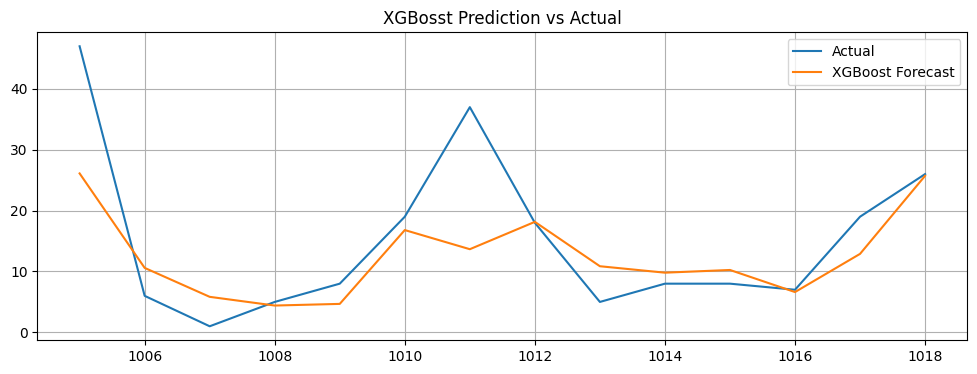

In [128]:
# Visualization the prediction
# XGBoost
plt.figure(figsize=(12, 4))
plt.plot(X_test.index, y_test.values, label='Actual')
plt.plot(X_test.index, y_pred_xgb, label='XGBoost Forecast')
plt.title("XGBosst Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [138]:
# From 2 test, XGBoost show better result
top_dishes = orders['Item Name'].unique()
future_predictions = []
for dish in top_dishes:
    dish_df = orders[orders['Item Name'] == dish].groupby(orders['Order Date'].dt.date)['Quantity'].sum().reset_index()
    dish_df['Order Date'] = pd.to_datetime(dish_df['Order Date'], dayfirst=True)

    dish_df['day'] = dish_df['Order Date'].dt.day
    dish_df['month'] = dish_df['Order Date'].dt.month
    dish_df['weekday'] = dish_df['Order Date'].dt.weekday
    
    # Add lag features
    for i in range(1, 15):  # lag 2 week
        dish_df[f'Quantity_{i}'] = dish_df['Quantity'].shift(i)
    dish_df = dish_df.dropna()

    # Split test and train
    X = dish_df.drop(columns=['Order Date', 'Quantity'])
    y = dish_df['Quantity']
    if len(dish_df) < 30:
        continue
    
    # Use last 200 row to test
    X_train, X_test = X[:-14], X[-14:]
    y_train, y_test = y[:-14], y[-14:]
    
    model_xgb = XGBRegressor(early_stopping_rounds=30, n_estimators=700, learning_rate=0.2)
    model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    # Make prediction
    y_pred_xgb = model_xgb.predict(X_test)
    total_pred = y_pred_xgb.sum()
    # print(f"Dish: {dish}. y_test shape: {y_test.shape}")
    # print(f"Dish: {dish}. y_test shape: {y_pred_xgb.shape}")
    xgb_rmse = mean_squared_error(y_test, y_pred_xgb)
    future_predictions.append({'dish': dish, 'predicted_total': total_pred, 'MSE': xgb_rmse})
    

In [139]:
for pred in future_predictions:
    print(f"Dish Name: {pred['dish']}. Predicted Total Sale: {pred['predicted_total']}. MSE metrics: {pred['MSE']}")

Dish Name: Plain Papadum. Predicted Total Sale: 176.40170288085938. MSE metrics: 80.13929748535156
Dish Name: Garlic Naan. Predicted Total Sale: 56.86317443847656. MSE metrics: 5.580321311950684
Dish Name: Mushroom Rice. Predicted Total Sale: 36.310752868652344. MSE metrics: 3.8892359733581543
Dish Name: Paneer Tikka Masala. Predicted Total Sale: 38.056884765625. MSE metrics: 26.13919448852539
Dish Name: Mango Chutney. Predicted Total Sale: 53.851478576660156. MSE metrics: 7.046206951141357
Dish Name: Plain Naan. Predicted Total Sale: 70.87069702148438. MSE metrics: 17.27908706665039
Dish Name: Tandoori Chicken (1/4). Predicted Total Sale: 16.528438568115234. MSE metrics: 0.08840682357549667
Dish Name: Vindaloo - Lamb. Predicted Total Sale: 14.456562042236328. MSE metrics: 0.0029728037770837545
Dish Name: Chapati. Predicted Total Sale: 43.62730407714844. MSE metrics: 4.906918525695801
Dish Name: Lamb Tikka. Predicted Total Sale: 17.25541114807129. MSE metrics: 0.25549638271331787
Dish 

In [140]:
top_5 = sorted(future_predictions, key=lambda x: x['predicted_total'], reverse=True)[:5]

for i, item in enumerate(top_5, 1):
    print(f"{i}. {item['dish']} → {item['predicted_total']:.1f} units")

1. Plain Papadum → 176.4 units
2. Pilau Rice → 104.8 units
3. Plain Naan → 70.9 units
4. Chicken Tikka Masala → 57.7 units
5. Garlic Naan → 56.9 units
